# Get thermal data


In [ ]:
from pandas import DataFrame, read_csv
from seaborn import scatterplot

from boilercv.stages.experiments.e230920_subcool import ALL_THERMAL_DATA, THERMAL_DATA

In [ ]:
BOILING = 97.33  # (C) inferred from mean pressure over the time span
TIME = "time"
BASE_TEMP = "T0cal (C)"
SURFACE_TEMP = "T_s (C)"
WATER_TEMPS = ["Tw1cal (C)", "Tw2cal (C)", "Tw3cal (C)"]
COLS = [BASE_TEMP, SURFACE_TEMP, *WATER_TEMPS, "Q34 (W)"]

In [ ]:
data = (
    (
        DataFrame(columns=COLS)
        .assign(
            **read_csv(
                ALL_THERMAL_DATA,
                usecols=[TIME, *COLS],
                parse_dates=[TIME],
                index_col=TIME,
            )
        )
        .loc["2023-09-20":"2023-09-21", :]
    )
    .resample("s")
    .mean()
    .ffill()
    .assign(
        T_w=lambda df: df[WATER_TEMPS].mean(axis="columns"),
        superheat=lambda df: df[SURFACE_TEMP] - BOILING,
        subcool=lambda df: BOILING - df.T_w,
    )
).loc[:, ["subcool", "superheat", BASE_TEMP, SURFACE_TEMP, "Q34 (W)"]]
data.to_hdf(THERMAL_DATA, key="data")

In [ ]:
data

,subcool,superheat,T0cal (C),T_s (C),Q34 (W)
time,,,,,
2023-09-20 16:20:24,4.408520,3.840404,157.347782,101.170404,10.681841
2023-09-20 16:20:25,4.408520,3.840404,157.347782,101.170404,10.681841
2023-09-20 16:20:26,4.408520,3.840404,157.347782,101.170404,10.681841
2023-09-20 16:20:27,4.577376,3.845475,157.280998,101.175475,10.675406
2023-09-20 16:20:28,4.577376,3.845475,157.280998,101.175475,10.675406
...,...,...,...,...,...
2023-09-20 18:37:41,9.753785,3.399101,298.369721,100.729101,35.323742
2023-09-20 18:37:42,9.753785,3.399101,298.369721,100.729101,35.323742
2023-09-20 18:37:43,9.763647,3.410967,298.563998,100.740967,35.489740


Text(0, 0.5, 'ΔT (K)')

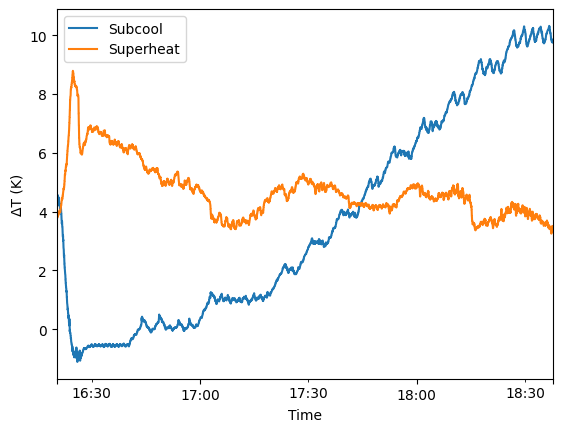

In [ ]:
ax = data[["subcool", "superheat"]].rename(columns=lambda col: col.capitalize()).plot()
ax.set_xlabel("Time")
ax.set_ylabel("ΔT (K)")

Text(0, 0.5, 'T (C)')

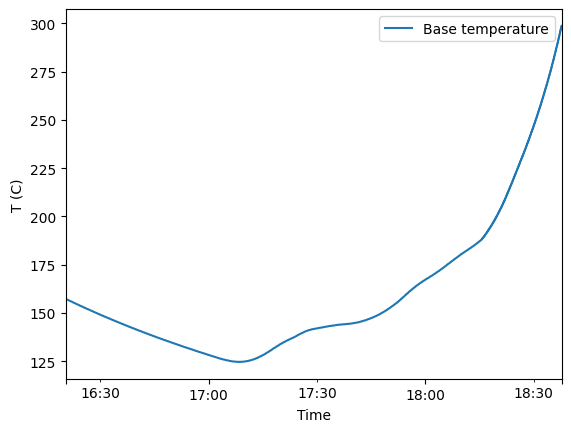

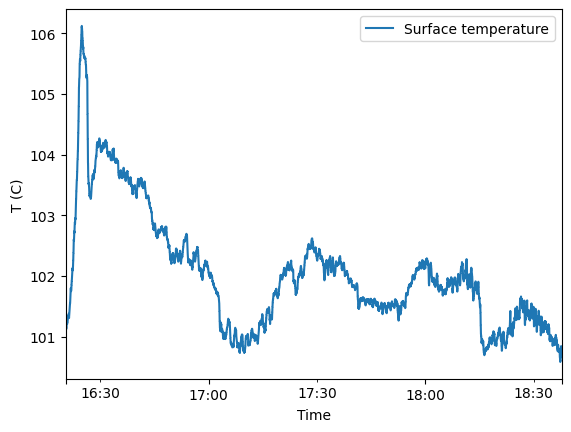

In [ ]:
ax = data[[BASE_TEMP]].rename(columns={BASE_TEMP: "Base temperature"}).plot()
ax.set_xlabel("Time")
ax.set_ylabel("T (C)")

ax = data[[SURFACE_TEMP]].rename(columns={SURFACE_TEMP: "Surface temperature"}).plot()
ax.set_xlabel("Time")
ax.set_ylabel("T (C)")

<Axes: xlabel='superheat', ylabel='Flux (W/cm^2)'>

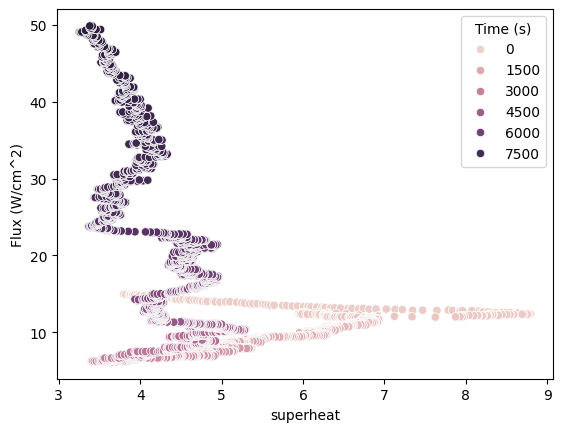

In [ ]:
scatterplot(
    data=data.reset_index().assign(**{
        "Time (s)": lambda df: (df.time - df.time[0]).dt.total_seconds(),
        "Flux (W/cm^2)": lambda df: df["Q34 (W)"] / 0.712557392,
    }),
    x="superheat",
    y="Flux (W/cm^2)",
    hue="Time (s)",
)